In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.neural_network import MLPClassifier
import mlflow
from imblearn.over_sampling import SMOTE
import mlflow.sklearn
from mlflow.models import infer_signature

In [7]:
# Load datasets
creditcard_df = pd.read_csv('E:/Git_repo/real-time-fraud-detection/data/creditcard_preprocessed.csv')
fraud_df = pd.read_csv('E:/Git_repo/real-time-fraud-detection/data/Processed_Fraud_Data.csv')

In [35]:
#### Check for missing values
#print("Missing values in creditcard_preprocessed.csv:")
#print(creditcard_df.isnull().sum())

#print("\nMissing values in Processed_Fraud_Data.csv:")
#print(fraud_df.isnull().sum())

In [ ]:
#####creditcard_df.drop(columns=['ip_address'], inplace=True)
#fraud_df.drop(columns=['ip_address'], inplace=True)

In [37]:
####print(creditcard_df.isnull().sum())  
#print(fraud_df.isnull().sum())  

In [38]:
# Feature and target separation
def prepare_data(df, target_col):
    # Handle datetime columns (e.g., signup_time, purchase_time)
    date_columns = ['signup_time', 'purchase_time']  # Replace with the actual datetime columns
    for col in date_columns:
        if col in df.columns:
            # Convert to datetime format
            df[col] = pd.to_datetime(df[col], errors='coerce')
            # Extract useful time-related features (year, month, day, hour, etc.)
            df[f'{col}_year'] = df[col].dt.year
            df[f'{col}_month'] = df[col].dt.month
            df[f'{col}_day'] = df[col].dt.day
            df[f'{col}_hour'] = df[col].dt.hour
            df[f'{col}_minute'] = df[col].dt.minute
            df[f'{col}_second'] = df[col].dt.second
            # Drop the original datetime column
            df.drop(columns=[col], inplace=True)

    # Handle categorical columns (e.g., sex, browser, country, source, device_id)
    categorical_columns = ['sex', 'browser', 'country', 'source', 'device_id', 'region']  # Add more if needed
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        if col in df.columns:
            df[col] = label_encoder.fit_transform(df[col].astype(str))

    # Separate features (X) and target (y)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    return X, y

In [39]:
X_credit, y_credit = prepare_data(creditcard_df, 'Class')
X_fraud, y_fraud = prepare_data(fraud_df, 'class')

# Train-test split
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42)


In [40]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

# Handle missing values before applying SMOTE
imputer = SimpleImputer(strategy='median')  # You can change strategy to 'mean' or 'most_frequent'
X_train_fraud = imputer.fit_transform(X_train_fraud)  # Fill missing values
y_train_fraud = y_train_fraud.dropna()  # Ensure target has no NaNs

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_fraud, y_train_fraud = smote.fit_resample(X_train_fraud, y_train_fraud)

In [42]:
# Handle imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_credit, y_train_credit = smote.fit_resample(X_train_credit, y_train_credit)
X_train_fraud, y_train_fraud = smote.fit_resample(X_train_fraud, y_train_fraud)


In [43]:
# Model training and evaluation
def train_and_evaluate(model, X_train, y_train, X_test, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f'\n=== {model_name} ===')
    print(classification_report(y_test, y_pred))
    print(f'ROC AUC Score: {roc_auc_score(y_test, y_prob)}')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    # AUC-ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'AUC-ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.show()

In [44]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)  # Added MLP model
}



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.90      0.12        98

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962

ROC AUC Score: 0.9812928160853536


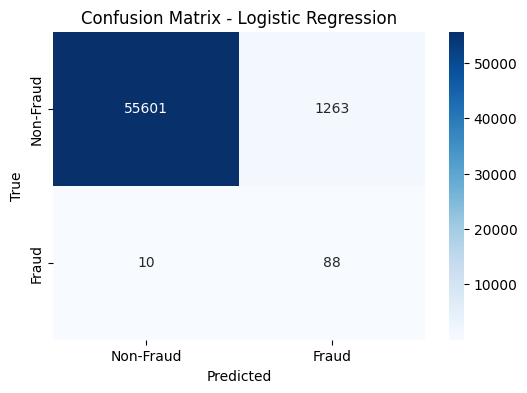

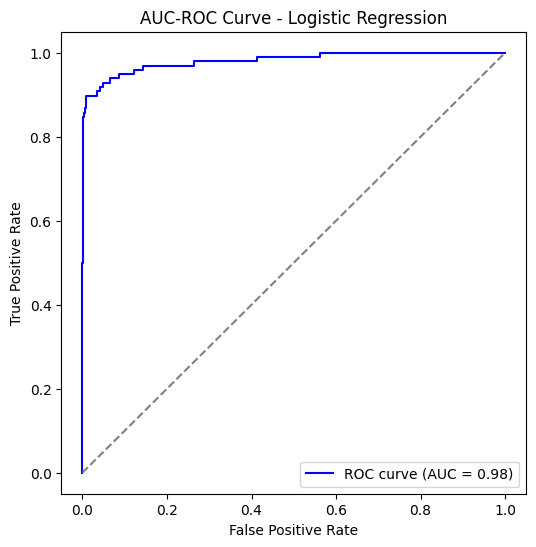


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     27373
           1       0.20      0.66      0.31      2850

    accuracy                           0.72     30223
   macro avg       0.58      0.70      0.57     30223
weighted avg       0.88      0.72      0.78     30223

ROC AUC Score: 0.765240341199325


e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


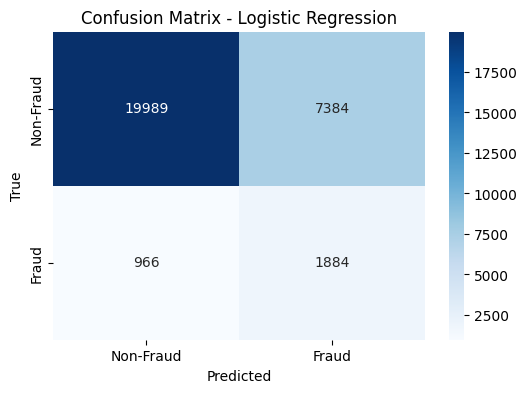

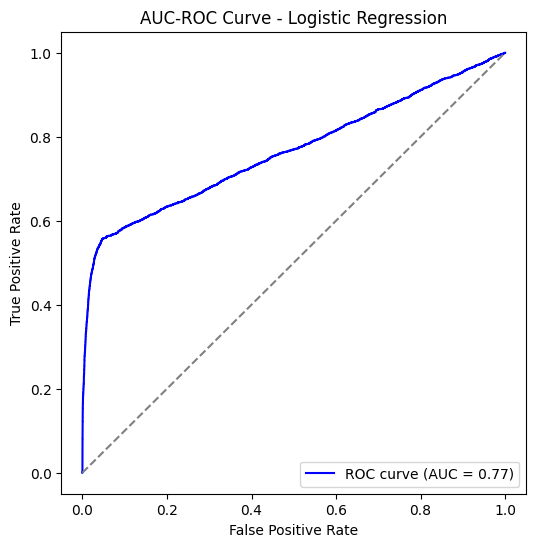


=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.85      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9903594720808977


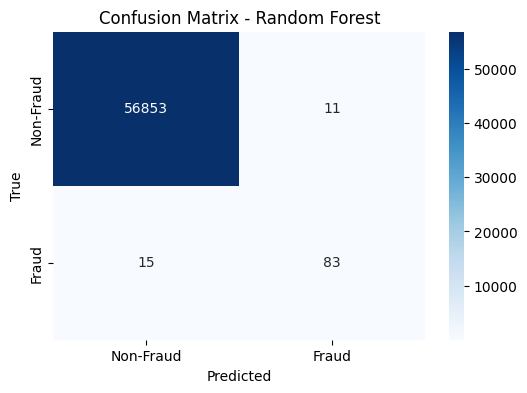

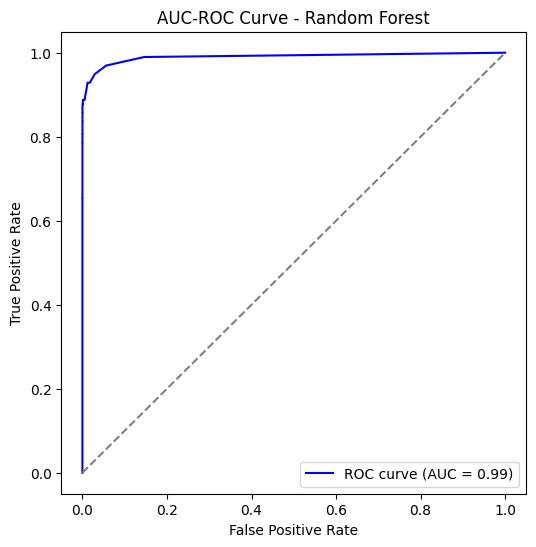

e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27373
           1       0.98      0.54      0.70      2850

    accuracy                           0.96     30223
   macro avg       0.97      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223

ROC AUC Score: 0.7742369898369568


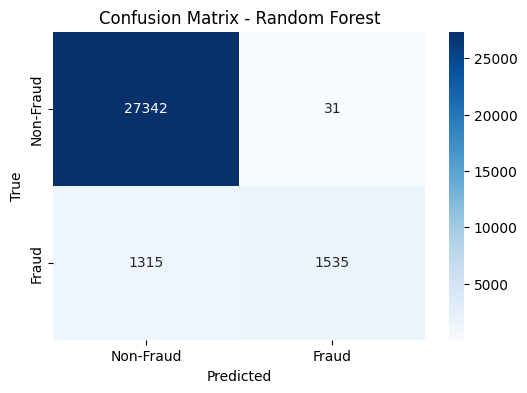

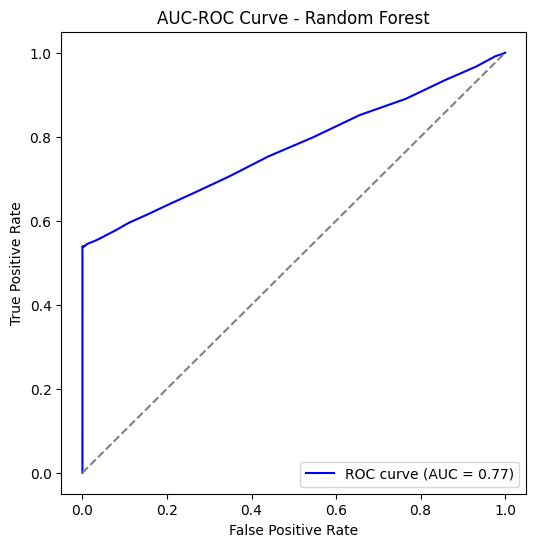


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.13      0.92      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.95      0.61     56962
weighted avg       1.00      0.99      0.99     56962

ROC AUC Score: 0.9906895650775785


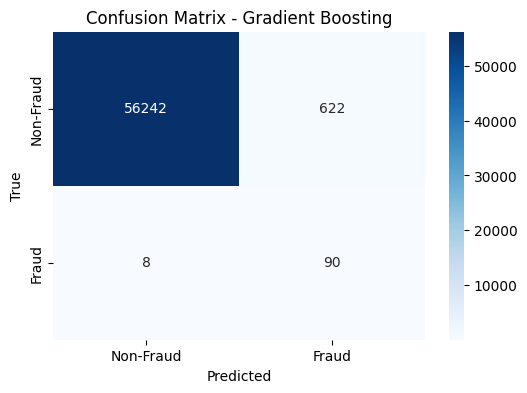

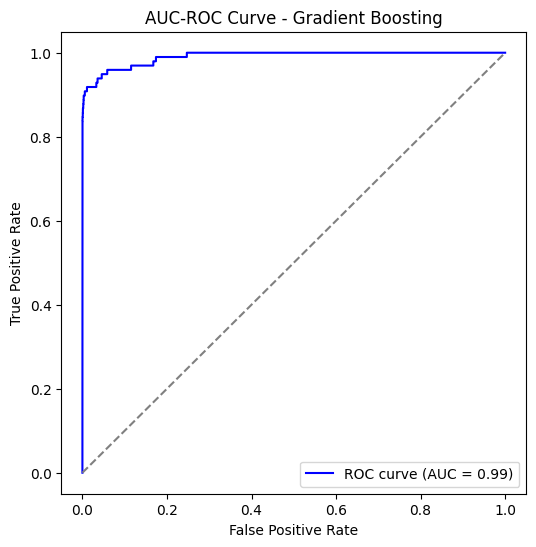


=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27373
           1       0.92      0.54      0.68      2850

    accuracy                           0.95     30223
   macro avg       0.94      0.77      0.83     30223
weighted avg       0.95      0.95      0.95     30223

ROC AUC Score: 0.77163864250917


e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(
e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


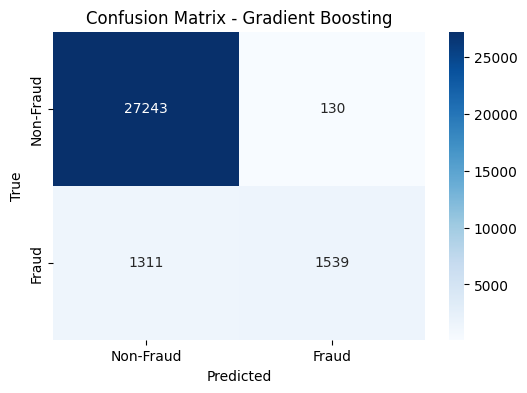

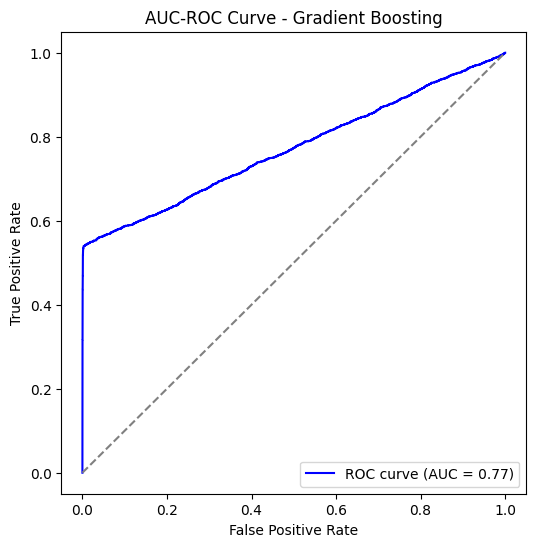


=== MLP ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.30      0.87      0.44        98

    accuracy                           1.00     56962
   macro avg       0.65      0.93      0.72     56962
weighted avg       1.00      1.00      1.00     56962

ROC AUC Score: 0.9754265099399355


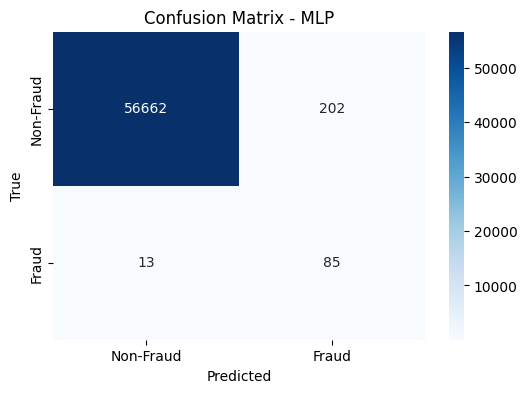

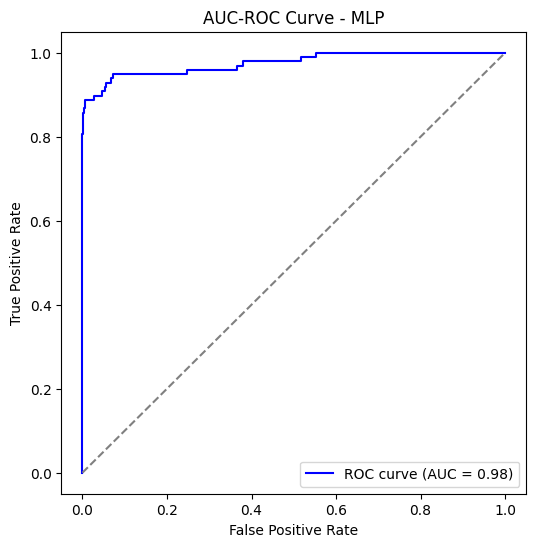

e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(
e:\Git_repo\real-time-fraud-detection\fdvenv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(



=== MLP ===
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     27373
           1       0.64      0.53      0.58      2850

    accuracy                           0.93     30223
   macro avg       0.79      0.75      0.77     30223
weighted avg       0.92      0.93      0.92     30223

ROC AUC Score: 0.7635626603497747


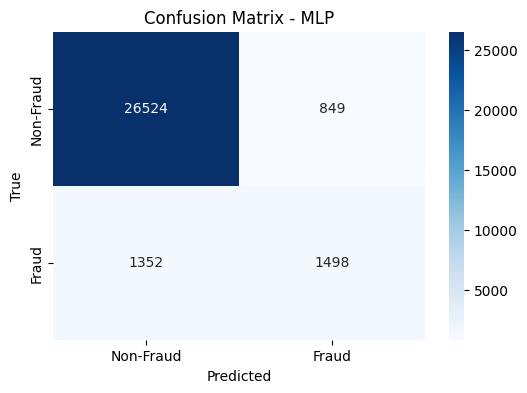

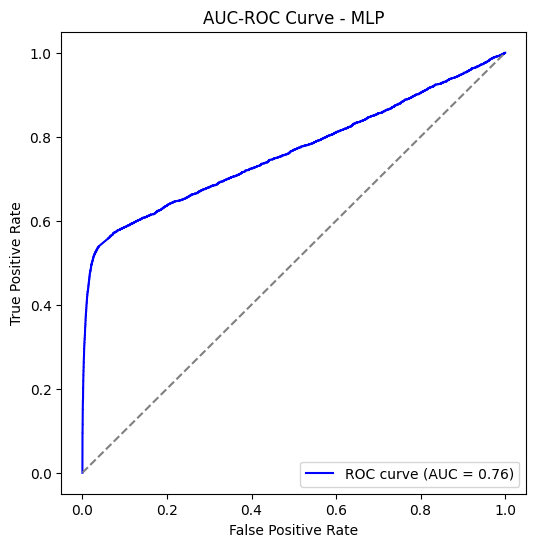

In [45]:
# Train and evaluate models
for model_name, model in models.items():
    train_and_evaluate(model, X_train_credit, y_train_credit, X_test_credit, y_test_credit, model_name)
    train_and_evaluate(model, X_train_fraud, y_train_fraud, X_test_fraud, y_test_fraud, model_name)

In [46]:
# Logging with MLflow
mlflow.set_experiment("Fraud Detection")
with mlflow.start_run():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_credit, y_train_credit)
    y_pred = model.predict(X_test_credit)
    
    mlflow.log_param("model", "RandomForest")
    mlflow.log_metric("accuracy", np.mean(y_pred == y_test_credit))
    mlflow.sklearn.log_model(model, "random_forest_model")
    
    print("Model logged successfully")

2025/02/10 19:05:40 INFO mlflow.tracking.fluent: Experiment with name 'Fraud Detection' does not exist. Creating a new experiment.
2025/02/10 19:11:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged successfully


In [49]:
# Set MLflow experiment (optional: this can be set globally as well)
mlflow.set_experiment("Real-time Fraud Detection")

# Start MLflow run
with mlflow.start_run():
    
    # Log parameters and metrics
    mlflow.log_param("model", "RandomForest")
    mlflow.log_metric("accuracy", np.mean(y_pred == y_test_credit))
    
    # Infer signature for the model
    signature = infer_signature(X_train_credit, model.predict(X_train_credit))
    input_example = X_train_credit.iloc[:2].to_dict(orient="list")  # Example input
    
    # Log model with signature and input example
    mlflow.sklearn.log_model(model, "random_forest_model", signature=signature, input_example=input_example)

    print("Model logged successfully with signature and input example")

2025/02/10 19:39:48 INFO mlflow.tracking.fluent: Experiment with name 'Real-time Fraud Detection' does not exist. Creating a new experiment.


Model logged successfully with signature and input example


In [ ]:


# Assuming you have X_credit, y_credit dataset
# Replace this with your actual dataset and split into training and test sets
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)

# Set MLflow experiment (optional: this can be set globally as well)
mlflow.set_experiment("Fraud Detection")

# Start MLflow run
with mlflow.start_run():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_credit, y_train_credit)
    y_pred = model.predict(X_test_credit)
    
    # Log parameters and metrics
    mlflow.log_param("model", "RandomForest")
    mlflow.log_metric("accuracy", np.mean(y_pred == y_test_credit))
    
    # Infer signature for the model
    signature = infer_signature(X_train_credit, model.predict(X_train_credit))
    input_example = X_train_credit.iloc[:2].to_dict(orient="list")  # Example input
    
    # Log model with signature and input example
    mlflow.sklearn.log_model(model, "random_forest_model", signature=signature, input_example=input_example)

    print("Model logged successfully with signature and input example")


Model logged successfully with signature and input example


In [48]:
import mlflow
import mlflow.sklearn
import numpy as np
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display, HTML

# Assuming you have X_credit, y_credit dataset
# Replace this with your actual dataset and split into training and test sets
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42)

# Set MLflow experiment (optional: this can be set globally as well)
mlflow.set_experiment("Fraud Detection")

# Start MLflow run
with mlflow.start_run():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_credit, y_train_credit)
    y_pred = model.predict(X_test_credit)
    
    # Log parameters and metrics
    mlflow.log_param("model", "RandomForest")
    mlflow.log_metric("accuracy", np.mean(y_pred == y_test_credit))
    
    # Infer signature for the model
    signature = infer_signature(X_train_credit, model.predict(X_train_credit))
    input_example = X_train_credit.iloc[:2].to_dict(orient="list")  # Example input
    
    # Log model with signature and input example
    mlflow.sklearn.log_model(model, "random_forest_model", signature=signature, input_example=input_example)

    print("Model logged successfully with signature and input example")

# Display the URL of the MLflow UI to view the results
display(HTML("<a href='http://127.0.0.1:5000' target='_blank'>Click here to view MLflow UI</a>"))

Model logged successfully with signature and input example
